In [1]:

import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub,plot_line
from util.consts import QueueEvent
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
dir_input="/data2/lichenni/path_perflow_busy_test"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
# for shard in np.arange(1000):
for shard in [0]:
    for n_flows in [2000]:
        for n_hosts in [21]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                if len(fid)==len(set(fid))==(n_hosts-1)*n_flows and np.all(fid[:-1] <= fid[1:]):
                    data_list.append((spec,topo_type_cur))
print(f"len(data_list): {len(data_list)}")
# Define a pattern to match the log line
log_pattern = re.compile(r"(\d+)\s+n:(\d+)\s+(\d+):(\d+)\s+(\d+)\s+(\w+)\s+ecn:(\d+)\s+(0b[0-9a-f]+)\s+(0b[0-9a-f]+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\((\d+)\)\s+(\d+)\s+(\d+)\s+(\d+)")
# Create a DataFrame
columns = ["timestamp", "node", "src_port", "queue", "queue_length", "event", "ecn", "src_addr", "dst_addr", 
           "src_port_num", "dst_port_num", "packet_type", "seq_num", "tx_timestamp", "priority_group", "packet_size", 
           "payload_size", "flow_id", "queue_event", "n_active_flows"]

len(data_list): 1


In [9]:

timestamp_to_period_pkt=[[1000000000,0]]
timestamp_to_period_flow=[[1000000000,0]]
timestamp_to_period_est=[[1000000000,0]]
peak_pkt=1.0
peak_flow=0.8
peak_est=0.6
queue_threshold=0
for spec_idx,(spec,topo_type) in enumerate(data_list):
    print(f"spec_idx: {spec_idx}")
    input_tmp=f"{dir_input}/{spec}"
    # List to hold parsed log data
    log_data = []

    # Read the log file
    with open(f'{input_tmp}/mix{topo_type}.log', 'r') as file:
        log_data = [match.groups() for line in file if (match := log_pattern.match(line))]
    fct=np.load(f'{input_tmp}/fct{topo_type}.npy')
    i_fct=np.load(f'{input_tmp}/fct_i{topo_type}.npy')
    fsize=np.load(f'{input_tmp}/fsize.npy')
    fat=np.load(f'{input_tmp}/fat.npy')
    sldn=fct/i_fct
    
    df = pd.DataFrame(log_data, columns=columns)

    # Convert relevant columns to appropriate data types
    df["timestamp"] = pd.to_numeric(df["timestamp"])
    df["seq_num"] = pd.to_numeric(df["seq_num"])
    df["flow_id"] = pd.to_numeric(df["flow_id"])
    df["qlen"]=pd.to_numeric(df["queue_length"])
    df["queue_event"]=pd.to_numeric(df["queue_event"])
    df["n_active_flows"]=pd.to_numeric(df["n_active_flows"])
    qlen_prev=0
    
    n_periods_pkt=0
    n_periods_flow=0
    n_periods_est=0
    
    n_flow_event=0
    flow_id_per_period_est=[]
    flow_id_per_period_cur_est=None
    flow_id_per_period_flow=[]
    flow_id_per_period_cur_flow=None
    
    for _, row in df.iterrows():
        seq_num = row["seq_num"]
        queue_event = row["queue_event"]
        timestamp = row["timestamp"]
        flow_id = row["flow_id"]
        qlen=row["qlen"]
        n_active_flows=row["n_active_flows"]
        assert n_active_flows>=0
        if queue_event == int(QueueEvent.QUEUE_START.value):
            assert timestamp_to_period_pkt[-1][1]==0
            assert qlen>queue_threshold
            timestamp_to_period_pkt.append([timestamp-1,0])
            timestamp_to_period_pkt.append([timestamp,peak_pkt])
            n_periods_pkt+=1
        elif queue_event == int(QueueEvent.QUEUE_END.value):
            assert timestamp_to_period_pkt[-1][1]==peak_pkt
            assert qlen<=queue_threshold
            timestamp_to_period_pkt.append([timestamp,peak_pkt])
            timestamp_to_period_pkt.append([timestamp+1,0])
        elif queue_event == int(QueueEvent.ARRIVAL_FIRST_PKT.value) or queue_event == int(QueueEvent.ARRIVAL_LAST_PKT.value):
            n_flow_event+=1
                
            if qlen>queue_threshold:
                if qlen_prev<=queue_threshold:
                    timestamp_to_period_flow.append([timestamp-1,0])
                    # start a new busy period
                    assert flow_id_per_period_cur_flow is None
                    flow_id_per_period_cur_flow=set()
                    n_periods_flow+=1
                timestamp_to_period_flow.append([timestamp,peak_flow])
                
            else:
                if qlen_prev>queue_threshold:
                    timestamp_to_period_flow.append([timestamp,peak_flow])
                    timestamp_to_period_flow.append([timestamp+1,0])
                    # terminate a new busy period
                    assert flow_id_per_period_cur_flow is not None and len(flow_id_per_period_cur_flow)>0
                    flow_id_per_period_flow.append(flow_id_per_period_cur_flow)
                    flow_id_per_period_cur_flow=None
            qlen_prev=qlen
            if flow_id_per_period_cur_flow is not None:
                flow_id_per_period_cur_flow.add(flow_id)
                
            if n_active_flows==0:
                if qlen > queue_threshold:
                    print(f"flow-{flow_id} has qlen-{qlen}")
                assert queue_event == int(QueueEvent.ARRIVAL_LAST_PKT.value) 
                assert flow_id_per_period_cur_est is not None
                flow_id_per_period_est.append(flow_id_per_period_cur_est)
                n_periods_est+=1
                flow_id_per_period_cur_est=None
                timestamp_to_period_est.append([timestamp,peak_est])
                timestamp_to_period_est.append([timestamp+1,0])
                
            elif flow_id_per_period_cur_est is None:
                assert queue_event == int(QueueEvent.ARRIVAL_FIRST_PKT.value)
                flow_id_per_period_cur_est=set()
                flow_id_per_period_cur_est.add(flow_id)     
                timestamp_to_period_est.append([timestamp-1,0])
                timestamp_to_period_est.append([timestamp,peak_est])
            else:
                flow_id_per_period_cur_est.add(flow_id)
                timestamp_to_period_est.append([timestamp,peak_est])
        else:
            assert "Invalid queue_event"
    timestamp_to_period_flow=np.array(timestamp_to_period_flow)
    timestamp_to_period_est=np.array(timestamp_to_period_est)
    timestamp_to_period_pkt=np.array(timestamp_to_period_pkt)
    print(f"timestamp_to_period_pkt: {timestamp_to_period_pkt.shape}, timestamp_to_period_flow: {timestamp_to_period_flow.shape}, timestamp_to_period_est: {timestamp_to_period_est.shape}")
    
    print(f"n_periods_pkt: {n_periods_pkt}, n_periods_flow: {n_periods_flow}, n_periods_est: {n_periods_est}, n_flow_event: {n_flow_event}")
    
    n_flows_per_period_est=[len(flow_id_per_period_est[i]) for i in range(len(flow_id_per_period_est))]
    n_flows_per_period_flow=[len(flow_id_per_period_flow[i]) for i in range(len(flow_id_per_period_flow))]
    
    unique_lengths, counts = np.unique(n_flows_per_period_est, return_counts=True)
                                                    
    # Calculate the weight for each period
    busy_periods=[]
    for length, count in zip(unique_lengths, counts):
        period_indices = np.where(n_flows_per_period_est == length)[0]
        # if count > 500:
        #     period_indices=np.random.choice(period_indices,500,replace=False)
        busy_periods.extend([flow_id_per_period_est[i] for i in period_indices])
    flow_id_per_period_est=busy_periods
    n_flows_per_period_est=[len(flow_id_per_period_est[i]) for i in range(len(flow_id_per_period_est))]
    
    print(f"{len(n_flows_per_period_est)} busy periods, len_per_period_est: {np.min(n_flows_per_period_est)}, {np.max(n_flows_per_period_est)}")
    print(f"{len(n_flows_per_period_flow)} busy periods, len_per_period_flow: {np.min(n_flows_per_period_flow)}, {np.max(n_flows_per_period_flow)}")
    n_flows_per_period_est_unique= [item for sublist in flow_id_per_period_est for item in sublist]
    assert len(n_flows_per_period_est_unique)==len(set(n_flows_per_period_est_unique))
    print(f"busy_periods_unique: {len(n_flows_per_period_est_unique)}")
    
    for flow_id_list in flow_id_per_period_est:
        if len(flow_id_list)==1:
            flow_id=list(flow_id_list)[0]
            print(f"flow-{flow_id} has size-{fsize[flow_id]}, slowdown-{sldn[flow_id]}, fct-{fct[flow_id]}, i_fct-{i_fct[flow_id]}")

spec_idx: 0


timestamp_to_period_pkt: (29977, 2), timestamp_to_period_flow: (34483, 2), timestamp_to_period_est: (139441, 2)
n_periods_pkt: 7494, n_periods_flow: 7415, n_periods_est: 29720, n_flow_event: 80000
29720 busy periods, len_per_period_est: 1, 14
7415 busy periods, len_per_period_flow: 1, 11
busy_periods_unique: 40000
flow-0 has size-39218, slowdown-1.3099182805328557, fct-46806, i_fct-35732
flow-1 has size-19498, slowdown-1.247239008126693, fct-23942, i_fct-19196
flow-2 has size-14208, slowdown-1.2141600108298363, fct-17938, i_fct-14774
flow-3 has size-2390, slowdown-1.0, fct-4864, i_fct-4864
flow-4 has size-12812, slowdown-1.2330461674398057, fct-16746, i_fct-13581
flow-9 has size-72547, slowdown-1.3479866140866315, fct-85798, i_fct-63649
flow-12 has size-18461, slowdown-1.2590026189436927, fct-23075, i_fct-18328
flow-13 has size-126339, slowdown-1.3637283303444154, fct-148285, i_fct-108735
flow-14 has size-6112, slowdown-1.1980482922557238, fct-9576, i_fct-7993
flow-20 has size-51173, s

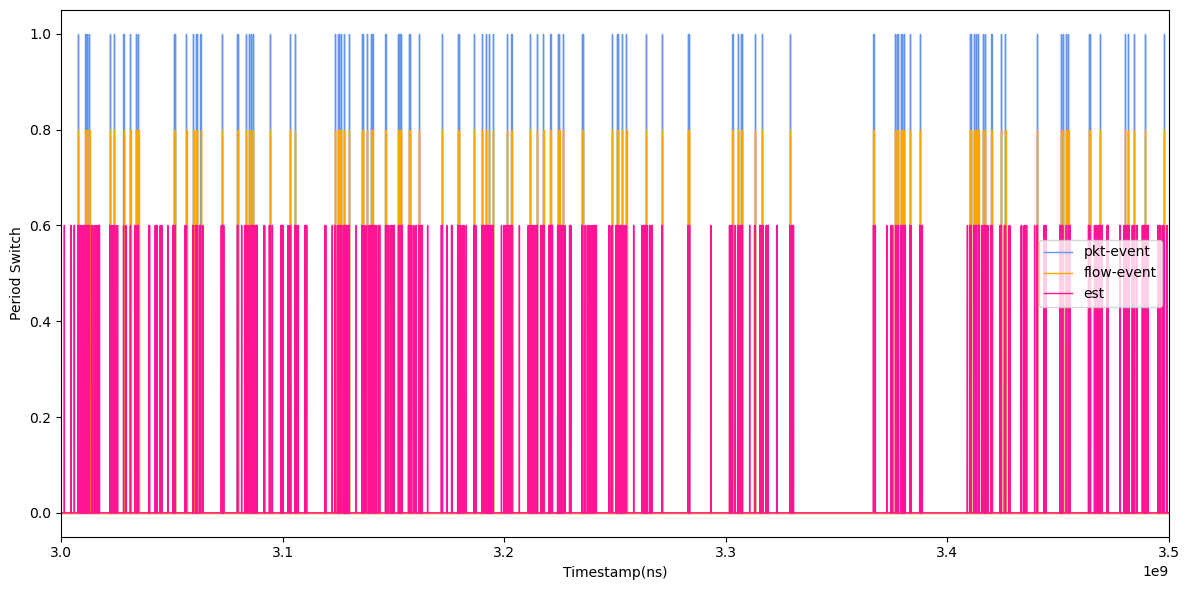

In [7]:
fig_idx=0
plt.figure(fig_idx,figsize=(12, 6))
plt.plot(timestamp_to_period_pkt[:,0],timestamp_to_period_pkt[:,1], label="pkt-event", linewidth=1,color=color_list[0])

plt.plot(timestamp_to_period_flow[:,0],timestamp_to_period_flow[:,1], label="flow-event", linewidth=1,color=color_list[1])

plt.plot(timestamp_to_period_est[:,0],timestamp_to_period_est[:,1], label="est", linewidth=1,color=color_list[2])

plt.xlabel('Timestamp(ns)')
plt.ylabel('Period Switch')
plt.legend()

plt.xlim([3000000000, 3500000000])
# plt.ylim([80, 100])
plt.tight_layout()



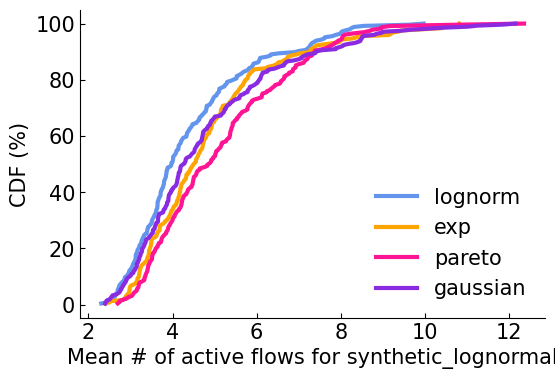

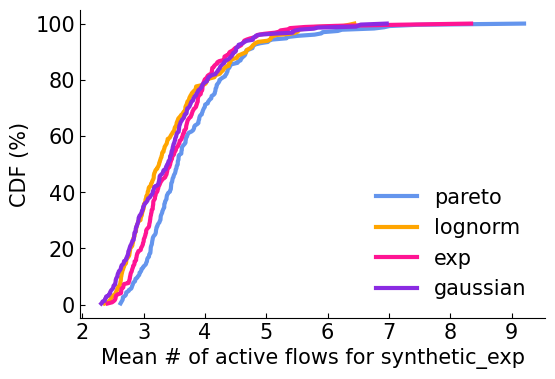

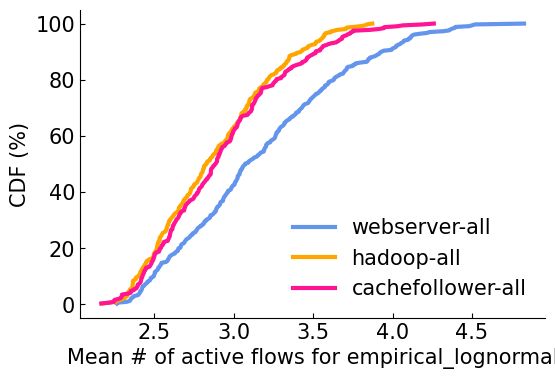

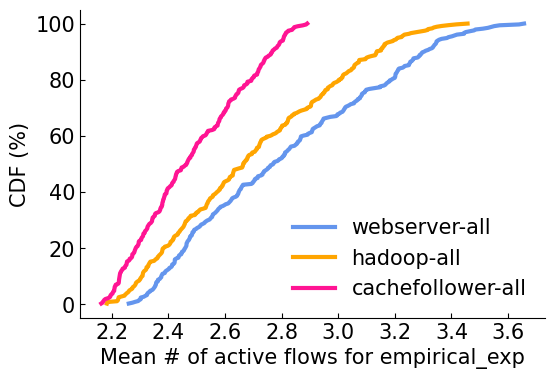

In [8]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx, target_str in enumerate(target_str_list):
    
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.mean(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Mean # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

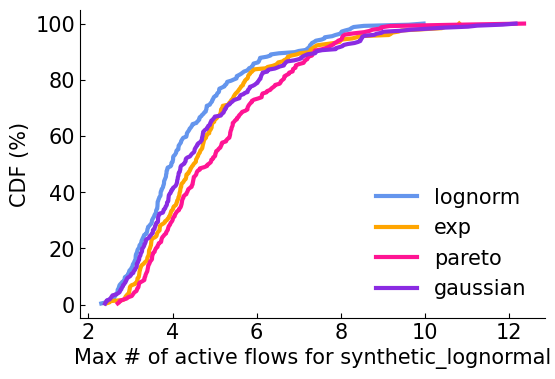

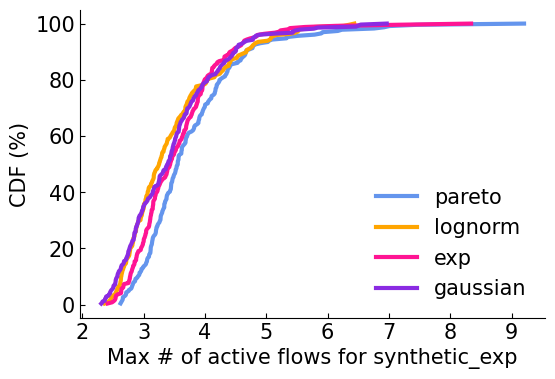

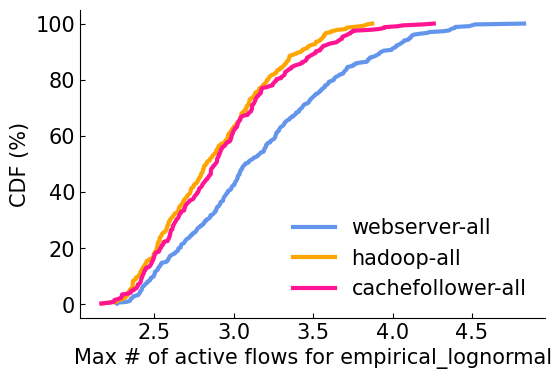

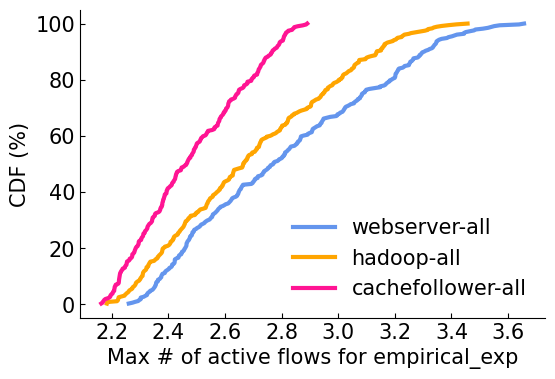

In [7]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx, target_str in enumerate(target_str_list):
    
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

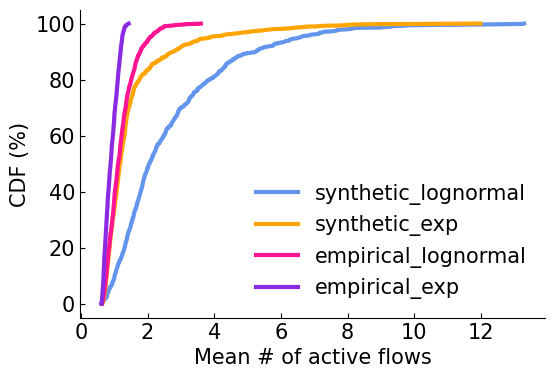

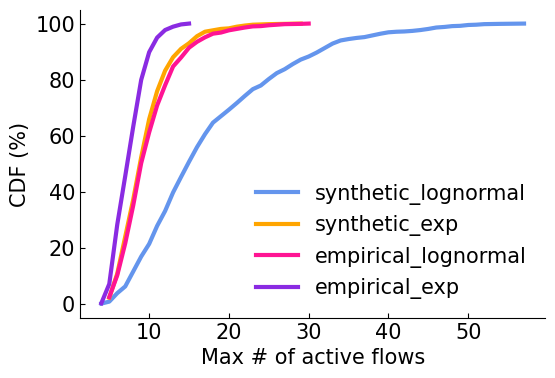

In [5]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
res_mean=[]
res_max=[]
for target_str in target_str_list:
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.mean(tmp))
    res_mean.append(np.array(res_tmp))
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.max(tmp))
    res_max.append(np.array(res_tmp))
    
plot_cdf(res_mean,None,legend_list,'Mean # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
fig_idx+=1

plot_cdf(res_max,None,legend_list,'Max # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)

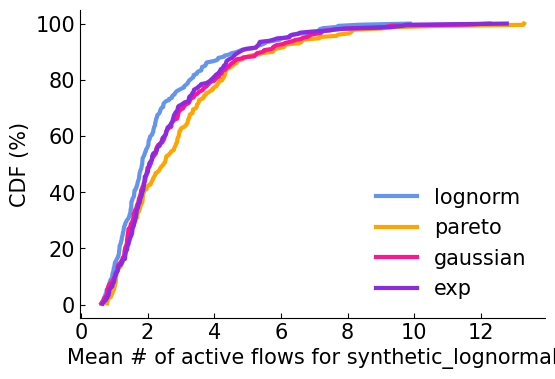

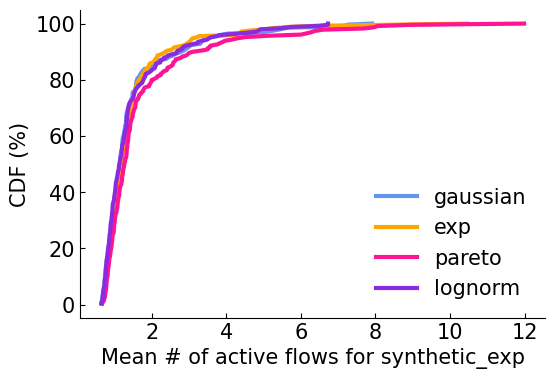

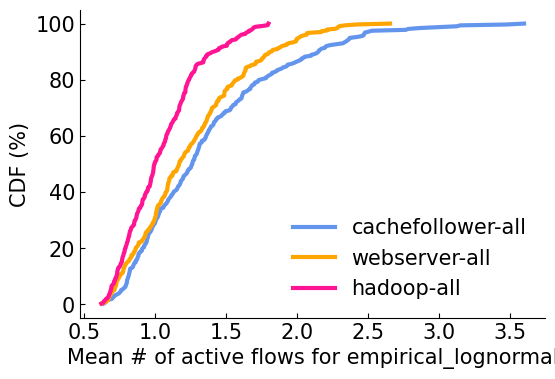

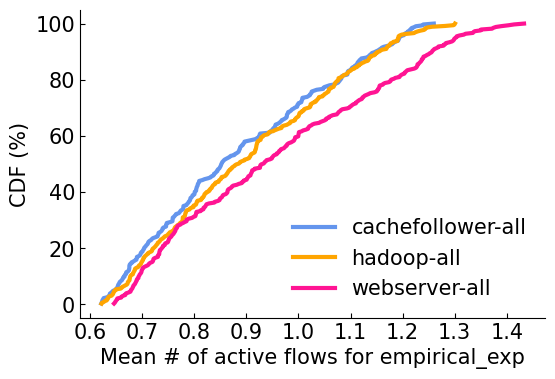

In [9]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.mean(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Mean # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

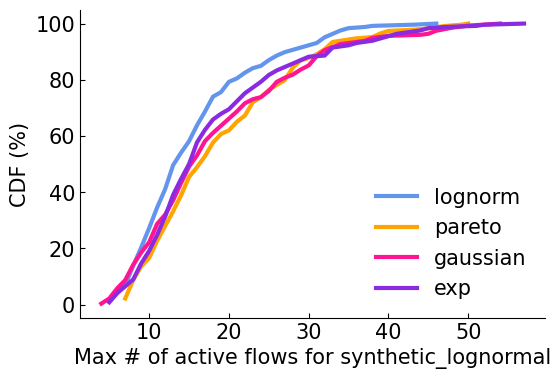

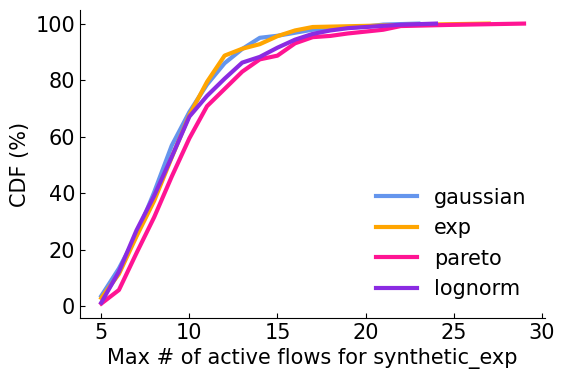

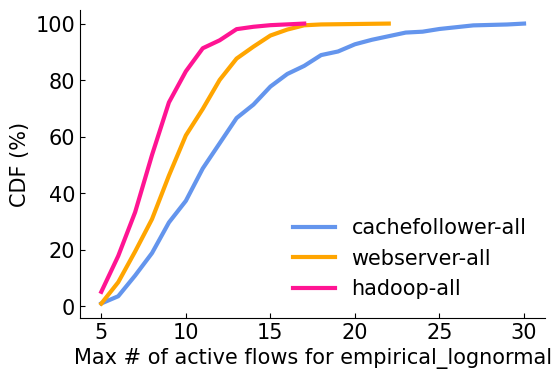

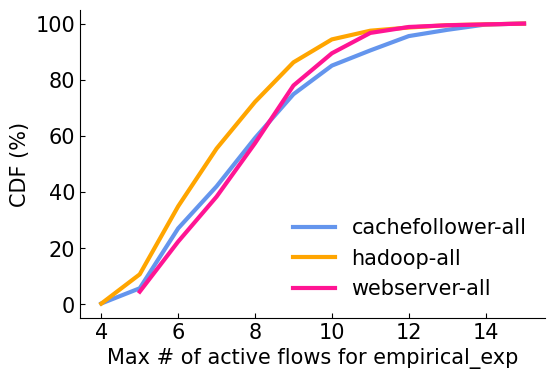

In [6]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1